# TIME DOMAIN SOLUTION FOR OSCILLATING REACTION NETWORK

# Reaction Network
<img src="Fig1.png" alt="Reaction Network" width="500"/>

# Notation

* ${\bf A}$ - Jacobian matrix
* $\alpha_n$ - amplitude of oscillation for species $n$
* $\Delta$ - $det {\bf A})$
* $i$ - indexes constants
* $k_i$, $k_d$ - positive constant
* $K$ - number of constants
* $\lambda$ - eigenvalue
* $n$ - indexes species
* $N$ - number of species
* $\omega_n$ - offset of species $n$
* $\phi_n$ - phase in radians
* $\tau$ - $tr({\bf A})$
* $\theta$ - frequency in radians
* ${\bf u}$ - forced input (kinetic constants for zeroth order rates)
* ${\bf x}$ ($N \times 1$) is the state vector
* $x_n$ (t) - time varying concentration of species $n$

Linear system
\begin{equation}
\dot{\bf x} = {\bf A} {\bf x} + {\bf u}\label{eq:linear}
\end{equation}

Notes
1. From the foregoing definitions, the oscillating characteristics are $\{\alpha_n, \theta, \phi_n, \omega_n \}$. So, there 7 OCs.
1. The parameters of the network are the $k_i$, $x_n (0)$. So, there are 8 parameters.

# Programming Preliminaries

In [1]:
from src.Oscillators import c1, c2, T, phi, r1, r2, t, b1, b2, m1, m2, h1, h2,   \
    alpha, omega, theta, S1, S2, k1, k2, k3, k4, k5, k6, k_d, x1, x1_0, x2, x2_0, I
from src.Oscillators.constants import PARAM_DCT
from src.Oscillators import util
from src.Oscillators.util import TIMES
from src.Oscillators.solver import Solver
from src.Oscillators.model import MODEL
from src.Oscillators.designer import Designer

import tellurium as te
import matplotlib.pyplot as plt
import sympy
from sympy import init_printing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import control
import lmfit

init_printing()

In [2]:
PARAM_DCT

{'k1': 1,
 'k2': 3.913120171941024,
 'k3': 4.913120171941024,
 'k4': 41.7719311459154,
 'k5': 15.001851381229434,
 'k6': 92.21558719235689,
 'S1': 5.000000000000001,
 'S2': 10.491854173592507,
 'x1_0': 5.000000000000001,
 'x2_0': 10.491854173592507,
 'k_d': 10.08873120928841,
 'theta': 6.283185307179586}

Many technical details of the symbolic solution are in symbolic algebra in the clas OscillatorSolution. We show major points in the deterivation by displaying properties of this object.

In [3]:
SOLUTION = Solver()
_ = SOLUTION.solve()

Numerical simulations are performed for the assignment of constants to certain values. These are specified below.

In [4]:
SYMBOL_DCT = util.makeSymbolDct(SOLUTION.x_vec, PARAM_DCT)
SYMBOL_DCT

# Antimony Model of the Oscillating Reaction Network

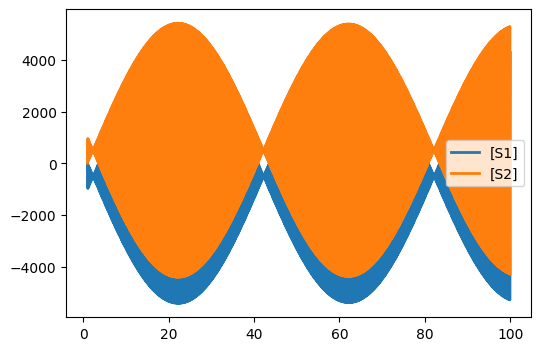

In [5]:
model = """
J1: S1 -> S2; k1*S1
J2: S2 -> S1; k2*S2
J3: S1 -> 2 S1; k3*S1
J4: S1 -> ; k4
J5: S2 -> ; k5*S1
J6: -> S2; k6

# Parameters are assigned programmatically below
k1 = 1
k2 = 10000
k3 = k1 + k2
k5 = k3 + 0.1
k6 = 41.7719311459154
k4 = 92.21558719235689
# Initial values assigned here
S1 = 5.000000000000001
S2 = 10.491854173592507
"""
rr = te.loada(model)
rr.simulate(1, 100, 1000)
rr.plot()

The antimony model of the oscillating network is displayed below.

In [6]:
print(MODEL)


J1: S1 -> S2; k1*S1
J2: S2 -> S1; k2*S2
J3: S1 -> 2 S1; k3*S1
J4: S1 -> ; k4
J5: S2 -> ; k5*S1
J6: -> S2; k6

# Parameters are assigned programmatically below
k1 = 1
k2 = 3.913120171941024
k3 = 4.913120171941024
k4 = 41.7719311459154
k5 = 15.001851381229434
k6 = 92.21558719235689
# Initial values assigned here
S1 = 5.000000000000001
S2 = 10.491854173592507




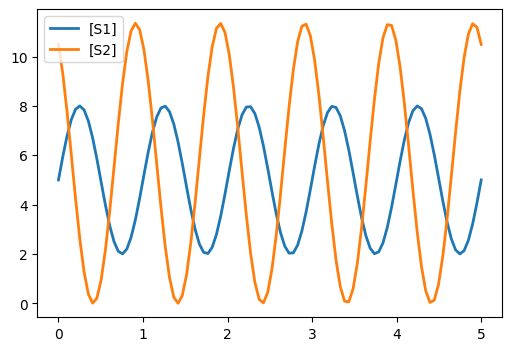

In [7]:
rr = te.loada(MODEL)
rr.simulate(0, 5, 100)
rr.plot()

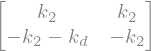

In [8]:
SOLUTION.A_mat

In [9]:
A = SOLUTION.A_mat.subs(SYMBOL_DCT)
A = np.array( [ [A[0], A[1]], [ A[2], A[3] ]]  )
A
                

array([[3.91312017194102, 3.91312017194102],
       [-14.0018513812294, -3.91312017194102]], dtype=object)

# Solution Details

Let ${\bf A} =
\begin{pmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{pmatrix}
$
Denote the determinant by $det({\bf A}) = \Delta = a_{11} a_{22} - a_{12} a_{21}$
and the trace by $\tau = tr({\bf A}) = a_{11} + a_{22}$. The eigenvalues are
$\lambda = \frac{1}{2} \left( - \tau \pm \sqrt{\tau^2 - 4 \Delta} \right)$.
So, to get pure imaginary eigenvalues, $\tau = 0$
and $\Delta > 0$.

<img src="Fig1.png" alt="Reaction Network" width="500"/>

## System Equations

In the sequel, we sometimes use $S_n$ to denote $x_n (t)$ to better draw out the connection between the reaction network and the system of differential equations for its solution.

This system equations are:
$
\begin{eqnarray}
\dot{S}_1 & = & - k_1 S_1 + +k_2 S_2 + k_3 S_1 - k_4 \\
\dot{S}_2 & = & k_1 S_1 - k_2 S_2 - k_5 S_1 + k_6  \\
\end{eqnarray}
$

Let ${\bf x} = 
\begin{pmatrix}
S_1 \\
S_2 \\
\end{pmatrix}
$,
$
{\bf A} = 
\begin{pmatrix}
k_3 - k_1 & k_2 \\
k_1 - k_5 & -k_2 \\
\end{pmatrix}
$, and
${\bf u} = 
\begin{pmatrix}
- k_4 \\
k_6  \\
\end{pmatrix}$

The full model is:
$\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$.

Note that
\begin{eqnarray}
\tau & = & k_3 -k_1 - k_2 \\
\Delta & = & (k_3 - k_1)(-k_2) - k_2 (k_1 - k_5) \\
& = & k_2 (k_5 - k_3) \\
\end{eqnarray}

## Constraints 

The following constraints are required to obtain a biologically plausible oscillating reaction network whose solution is a linear ODE:
* C1: The rate laws of the reaction network are a linear function of ${\bf x} (t)$, which we also denote by $S_n$.
* C2: $x_n(t) \geq 0$
* C3: $\tau = 0$
* C4: $\Delta > 0$

## Implications of the constraints

C3 implies that $k_3 = k_1 + k_2$

C4 implies that $k_5 > k_3$. We define $k_d = k_5 - k_3 > 0$

Applying the foregoing to the ${\bf A}$ matrix, we first note that
\begin{align*}
k_1 - k_5 & = & k_1 - k_3 -k_d \\
& = & k_3 - k_2 - k_3 - k_d \\
& = & -k_2 - k_d \\
\end{align*}
And so,
$
{\bf A} =
\begin{pmatrix}
k_2 & k_2 \\
-k_2 - k_d & -k_2 \\
\end{pmatrix}
$, and $\Delta = k_2 k_d$.

Recall, that with the constraints, the eigevalues are $\pm \sqrt{- \Delta}$.
Thus, the frequency of oscillation is
\begin{equation}
\theta = \sqrt{\Delta} = \sqrt{k_2 k_d} \label{eq:theta}
\end{equation}

We can check this result with a simulation.

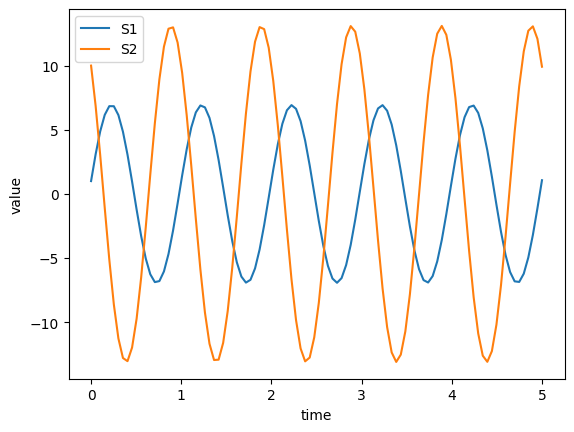

In [10]:
_ = SOLUTION.simulate(expression=SOLUTION.A_mat, is_plot=True)

## Eigenvectors for Pure Imaginary Eigenvalues

Note that since $k_d > 0$, ${\bf A}$ is nonsingular, and so we can calculate eigenvectors directly.

In [11]:
sympy.print_latex(SOLUTION.A_mat.eigenvects()[1][2])

\left[ \left[\begin{matrix}- \frac{i \sqrt{k_{2}} \sqrt{k_{d}}}{k_{2} + k_{d}} - \frac{k_{2}}{k_{2} + k_{d}}\\1\end{matrix}\right]\right]


The eigenvalues are:

$
\begin{eqnarray}
\lambda_1 &=& - \sqrt{k_d k_2} i \\
\lambda_2 &=&  + \sqrt{k_d k_2} i
\end{eqnarray}
$

We define $\theta = \sqrt{k_d k_2}$, and so
$\lambda_n = (-1)^n \theta i$.

The eigenvectors are:
$
{\bf e}  =
\begin{pmatrix}
\frac{- k_2 \pm \theta i}{k_2 + k_d} \\
1 \\
\end{pmatrix} \\
$

## Fundamental Matrix (${\bf F}$)

The fundamental matrix ${\bf F}$ is a marix with columns that are orthogonal solutions to the homogeneous system. We use the fundamental matrix to construct the particular solution.

If the eigenvector ${\bf w}$ and/or
eigenvalue $\lambda$ are complex, then
${\bf w} e^{\lambda} = {\bf v}_1 + i {\bf v}_2$ for
some real vectors ${\bf v}_n$.
By theorem, the ${\bf v}_n$ are independent solutions to
the differential equation
and so the solution to the IVP
is $\sum_{n=1}^2 c_n v_n$ for $c_n$ chosen
based on the initial values.
Hence, ${\bf F} =
\left[ \begin{matrix} {\bf v}_1 & {\bf v}_2 \\ \end{matrix} \right]$.

In [12]:
sympy.print_latex(SOLUTION.fund_mat)

\left[\begin{matrix}- \frac{k_{2} \cos{\left(t \theta \right)}}{k_{2} + k_{d}} + \frac{\theta \sin{\left(t \theta \right)}}{k_{2} + k_{d}} & - \frac{k_{2} \sin{\left(t \theta \right)}}{k_{2} + k_{d}} - \frac{\theta \cos{\left(t \theta \right)}}{k_{2} + k_{d}}\\\cos{\left(t \theta \right)} & \sin{\left(t \theta \right)}\end{matrix}\right]


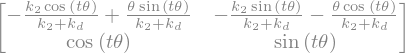

In [13]:
SOLUTION.fund_mat

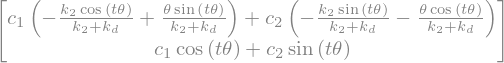

In [14]:
SOLUTION.homogeneous_x_vec

## Solution for Nonhomogeneous System

The equation with forced inputs is $\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$,
where ${\bf u}$ is the forced input.
The solution with forced inputs has the form
${\bf x}^H + {\bf x}^P$, where ${\bf x}^H$
is a solution to the homogeneous system and ${\bf x}^P$ is a particular solution
for the forced input ${\bf u}$.

Recall the following for solutions of nonhomogeneous systems.
Let ${\bf F}$ be the fundamental matrix for $\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$.
We want to construct a particular solution
${\bf x}^P = {\bf F} {\bf v}$, for the unknown vector ${\bf v}$.

Substituting,

\begin{eqnarray}
\dot{\bf F} {\bf v} + {\bf F} \dot{\bf v} & = & {\bf A} {\bf F} {\bf v} + {\bf u} \\
{\bf A} {\bf F} {\bf v} + {\bf F} \dot{\bf v} & = & {\bf A} {\bf F} {\bf v} + {\bf u} \\
{\bf F} \dot{\bf v} & = & {\bf u} \\
{\bf v} = \int \left( {\bf F}^{-1} {\bf u} \right)dt
\end{eqnarray}

Note that there is an integration constant as well, but this need not be considered
since all values of the constant still result in a valid particular solution.
Also, the inverse exists since the columns of ${\bf X}_F$ are orthogonal.

This calculation can be done with symbolic algebra, but it takes a few minutes on a modern laptop.

In [15]:
sympy.print_latex(SOLUTION.particular_x_vec)

\left[\begin{matrix}\frac{- k_{2}^{2} k_{4} \cos{\left(t \theta \right)} - k_{2}^{2} k_{4} + k_{2}^{2} k_{6} \cos{\left(t \theta \right)} + k_{2}^{2} k_{6} - k_{2} k_{4} k_{d} \cos{\left(t \theta \right)} - k_{2} k_{4} k_{d} + k_{2} k_{4} \theta \sin{\left(t \theta \right)} - k_{2} k_{6} \theta \sin{\left(t \theta \right)} + k_{4} k_{d} \theta \sin{\left(t \theta \right)} + k_{6} \theta^{2}}{\theta^{2} \left(k_{2} + k_{d}\right)}\\\frac{k_{2} k_{4} \cos{\left(t \theta \right)} + k_{2} k_{4} - k_{2} k_{6} \cos{\left(t \theta \right)} - k_{2} k_{6} + k_{4} k_{d} \cos{\left(t \theta \right)} + k_{4} k_{d}}{\theta^{2}}\end{matrix}\right]


${\bf x} = {\bf x}^p + {\bf x}^h$, where the superscripts indicate the particular and homogeneous solutioins. This will contain the constants $c_1, c_2$ that we find by using the initial conditions ${\bf x}(0) = \begin{pmatrix} x_{10} \\  x_{20} \end{pmatrix}$.

In [16]:
SYMBOL_DCT

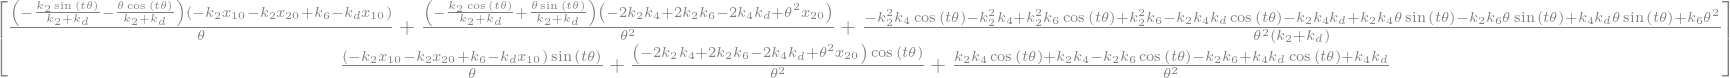

In [17]:
SOLUTION.raw_x_vec

We can check that dervivation with a numerical simulation to see if the result is the same as the Antimony simulation for the same parameter values.

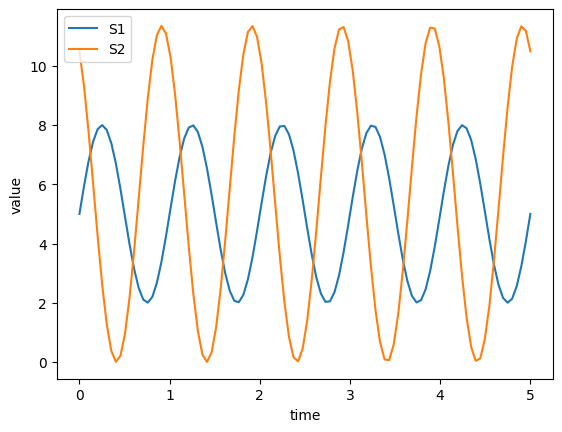

In [18]:
_ = SOLUTION.simulate(expression=SOLUTION.raw_x_vec, is_plot=True)

## Restructuring the Nonhomogeneous Solution

To goal here is to restructure the solution to isolate the OCs. We take advantage of the following trigonometric equality.

$$a cos(t) + b sin(t) = \sqrt{a^2 + b^2} sin(t + tan^{-1}\frac{a}{b})
$$

Applying this relationship requires gathering terms appropriately. The result below strcutures the solution into:
* $\alpha_n$: the amplitude of $x_n (t)$
* $\phi_n$: the phase of $x_n (t)$
* $\omega_n$: the offset of the sinusoid

Note that the frequency for both solutions is $\theta = \sqrt{k_2 k_d}$.

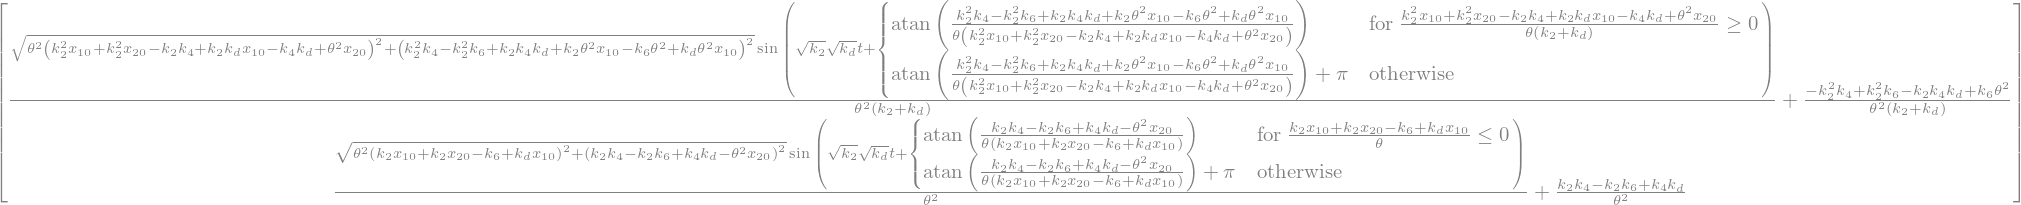

In [19]:
SOLUTION.x_vec

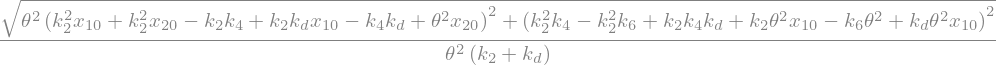

In [20]:
SOLUTION.alphas[0]

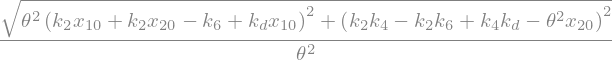

In [21]:
SOLUTION.alphas[1]

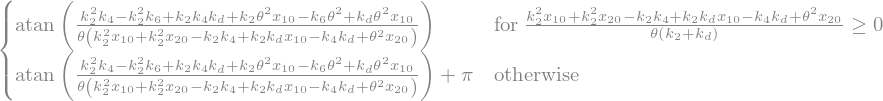

In [22]:
SOLUTION.phis[0]

In [23]:
sympy.print_latex(SOLUTION.phis[0])

\begin{cases} \operatorname{atan}{\left(\frac{k_{2}^{2} k_{4} - k_{2}^{2} k_{6} + k_{2} k_{4} k_{d} + k_{2} \theta^{2} x_{1 0} - k_{6} \theta^{2} + k_{d} \theta^{2} x_{1 0}}{\theta \left(k_{2}^{2} x_{1 0} + k_{2}^{2} x_{2 0} - k_{2} k_{4} + k_{2} k_{d} x_{1 0} - k_{4} k_{d} + \theta^{2} x_{2 0}\right)} \right)} & \text{for}\: \frac{k_{2}^{2} x_{1 0} + k_{2}^{2} x_{2 0} - k_{2} k_{4} + k_{2} k_{d} x_{1 0} - k_{4} k_{d} + \theta^{2} x_{2 0}}{\theta \left(k_{2} + k_{d}\right)} \geq 0 \\\operatorname{atan}{\left(\frac{k_{2}^{2} k_{4} - k_{2}^{2} k_{6} + k_{2} k_{4} k_{d} + k_{2} \theta^{2} x_{1 0} - k_{6} \theta^{2} + k_{d} \theta^{2} x_{1 0}}{\theta \left(k_{2}^{2} x_{1 0} + k_{2}^{2} x_{2 0} - k_{2} k_{4} + k_{2} k_{d} x_{1 0} - k_{4} k_{d} + \theta^{2} x_{2 0}\right)} \right)} + \pi & \text{otherwise} \end{cases}


In [24]:
sympy.print_latex(SOLUTION.phis[1])

\begin{cases} \operatorname{atan}{\left(\frac{k_{2} k_{4} - k_{2} k_{6} + k_{4} k_{d} - \theta^{2} x_{2 0}}{\theta \left(k_{2} x_{1 0} + k_{2} x_{2 0} - k_{6} + k_{d} x_{1 0}\right)} \right)} & \text{for}\: \frac{k_{2} x_{1 0} + k_{2} x_{2 0} - k_{6} + k_{d} x_{1 0}}{\theta} \leq 0 \\\operatorname{atan}{\left(\frac{k_{2} k_{4} - k_{2} k_{6} + k_{4} k_{d} - \theta^{2} x_{2 0}}{\theta \left(k_{2} x_{1 0} + k_{2} x_{2 0} - k_{6} + k_{d} x_{1 0}\right)} \right)} + \pi & \text{otherwise} \end{cases}


In [25]:
sympy.print_latex(SOLUTION.omegas[0])

\frac{- k_{2}^{2} k_{4} + k_{2}^{2} k_{6} - k_{2} k_{4} k_{d} + k_{6} \theta^{2}}{k_{2} \theta^{2} + k_{d} \theta^{2}}


In [26]:
sympy.print_latex(SOLUTION.omegas[1])

\frac{k_{2} k_{4} - k_{2} k_{6} + k_{4} k_{d}}{\theta^{2}}


Again, we do a simulation to cross check the result.

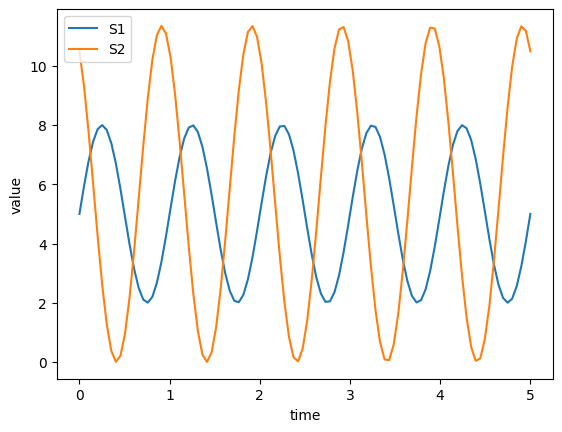

In [27]:
_ = SOLUTION.simulate(expression=SOLUTION.x_vec, is_plot=True)

# Conditions for C2 (x(t) >= 0 )

## $x_1 (t)$

In [28]:
name_dct = dict(PARAM_DCT)
name_dct

{'k1': 1,
 'k2': 3.913120171941024,
 'k3': 4.913120171941024,
 'k4': 41.7719311459154,
 'k5': 15.001851381229434,
 'k6': 92.21558719235689,
 'S1': 5.000000000000001,
 'S2': 10.491854173592507,
 'x1_0': 5.000000000000001,
 'x2_0': 10.491854173592507,
 'k_d': 10.08873120928841,
 'theta': 6.283185307179586}

In [29]:
names =  ['k1', 'k3', 'k_d']
for name in names:
    name_dct[name] = 0
keys = list(name_dct.keys())
for name in keys:
    if name in names:
        name_dct[name] = 0
    else:
        del name_dct[name]
symbol_dct = util.makeSymbolDct(SOLUTION.x_vec[0], name_dct)
name_dct, symbol_dct

({'k1': 0, 'k3': 0, 'k_d': 0}, {k_d: 0})

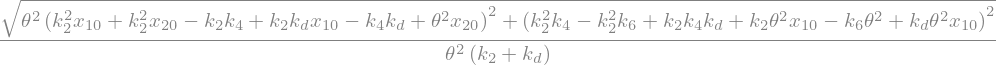

In [30]:
aa1 = SOLUTION.alphas[0]
aa1

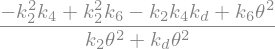

In [31]:
oo1 = SOLUTION.omegas[0]
oo1

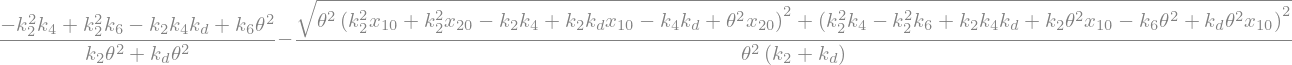

In [32]:
diff1 = oo1 - aa1
diff1

In [33]:
sympy.print_latex(sympy.limit(diff1, k2, sympy.oo))

\infty \operatorname{sign}{\left(- k_{4} + k_{6} - \sqrt{k_{4}^{2} - 2 k_{4} k_{6} + k_{6}^{2} + \theta^{2} x_{1 0}^{2} + 2 \theta^{2} x_{1 0} x_{2 0} + \theta^{2} x_{2 0}^{2}} \right)}


## $x_2(t)$

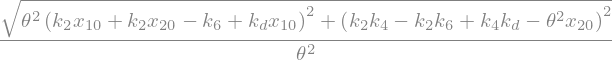

In [34]:
aa2 = SOLUTION.alphas[1]
aa2

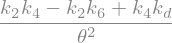

In [35]:
oo2 = SOLUTION.omegas[1]
oo2

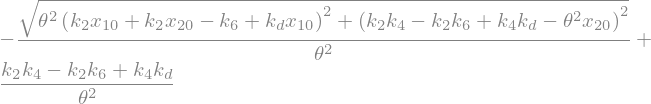

In [36]:
diff2 = oo2 - aa2
diff2

In [37]:
sympy.print_latex(sympy.limit(diff2, k2, sympy.oo))

\infty \operatorname{sign}{\left(k_{4} - k_{6} - \sqrt{k_{4}^{2} - 2 k_{4} k_{6} + k_{6}^{2} + \theta^{2} x_{1 0}^{2} + 2 \theta^{2} x_{1 0} x_{2 0} + \theta^{2} x_{2 0}^{2}} \right)}


# Sensitivity Analysis

In [38]:
k2, k3, k5, theta = sympy.symbols("k2, k3, k5, theta")

In [39]:
EXPR = sympy.sqrt((k5 - k3)*k2)
EXPR

$
\frac{\partial E}{\partial k_2}  =  \frac{ \sqrt{k_5 - k_3}}{2\sqrt{k_2}}
$

\begin{eqnarray}
C_{\theta, k_2} & = &  \frac{\sqrt{k_5 - k_3}}{2 \sqrt{k_2}} \frac{k_2}{\sqrt{k_2(k_5 -k_3)}} \\
& = & \frac{\sqrt{k_5 - k_3}}{2\sqrt{k_2}} \frac{k_2}{\sqrt{k_2(k_5 -k_3)}} \\
& = & \frac{1}{2}
\end{eqnarray}

In [40]:
type(EXPR)

sympy.core.power.Pow

In [41]:
def calculateNormalizedControl(k, is_latex=False):
    """
    Calculates the normalized control coefficient w.r.t. k
    
    Args
        k: sympy.symbol
        
    Returns
        sympy.expression
    
    """
    result = sympy.simplify(k*sympy.Derivative(EXPR, k).doit()/EXPR)
    if is_latex:
        return sympy.print_latex(result)
    else:
        return result

# Tests
result = calculateNormalizedControl(k5, is_latex=True)
result

- \frac{k_{5}}{2 k_{3} - 2 k_{5}}


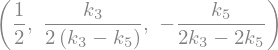

In [42]:
is_latex = False
calculateNormalizedControl(k2, is_latex=is_latex), calculateNormalizedControl(k3, is_latex=is_latex), calculateNormalizedControl(k5, is_latex=is_latex)

# Design

In [51]:
designer = Designer.design(theta=6.0, alpha=1, phi=0, omega=3)
designer.find()

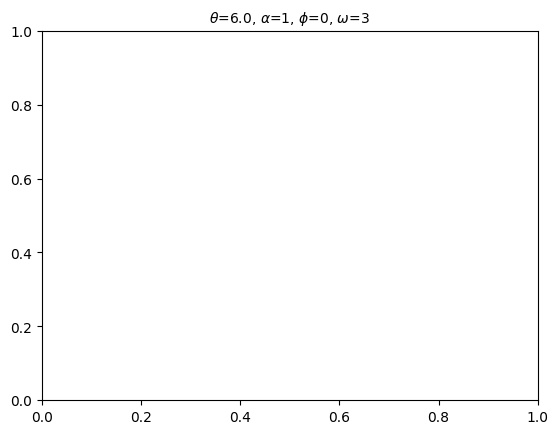

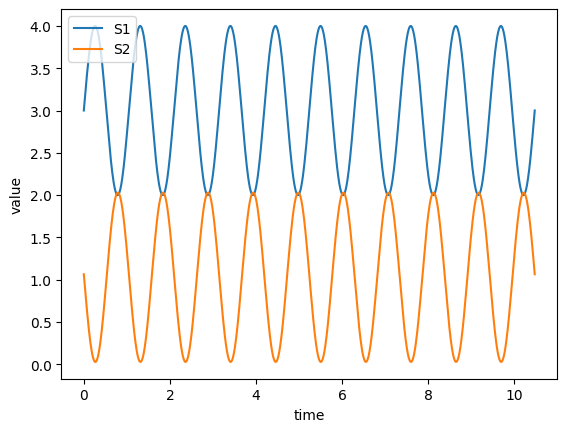

In [52]:
designer.plotFit()